# 潜在ディレクトリ配分によるトピックモデルの構築
- 「[第3版]Python機械学習プログラミング 達人データサイエンティストによる理論と実践」を参考に実装

In [1]:
#インストール（必要あれば）

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 映画レビューのデータセット（http://ai.stanford.edu/~amaas/data/sentiment/）
df = pd.read_csv('movie_data.csv')

### データの確認

In [4]:
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [5]:
df.shape

(50000, 2)

In [6]:
#単語数を数える
#各文書ごとに単語数を格納したリストの作成
word_count = [len(review.split()) for review in df['review']]

x = 0
for count in word_count:
    x += count
f'総単語数: {x} words'

'総単語数: 11557847 words'

### (1) BoW行列の作成（単語のベクトル化とストップワードの除去）
- (stopword list) https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/feature_extraction/_stop_words.py
- (document) https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- (tokenization)https://scikit-learn.org/1.1/modules/feature_extraction.html#text-feature-extraction

In [7]:
#インポート
from sklearn.feature_extraction.text import CountVectorizer 

count = CountVectorizer(stop_words='english', #sklearnライブラリの英語用ストップワードリストを用いる
                        max_df=0.1, #出現頻度が10%以上の単語は除去される
                        max_features=5000) #出現頻度の高い上位5000語のみを特徴量として使用

X = count.fit_transform(df['review'].values) #レビューデータを使ってBow行列を作成

In [8]:
#BoW行列を確認
print(X.shape) #(50,000件のレビューデータ×出現頻度上位5000語)
X.toarray() #出現頻度が格納

(50000, 5000)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
len(count.vocabulary_)

5000

In [10]:
#除去された単語を10個確認
list(count.stop_words_)[:10]

['starman',
 'bombards',
 'petitioned',
 'jeeharv',
 'edmednson',
 'encompassed',
 'gabriela',
 'kellerkinder',
 'regretting',
 'outasight']

In [11]:
f'{len(list(count.stop_words_))}語が除去されている'

'96583語が除去されている'

### (2) LatentDirichletAllocationクラスを使ってトピックの予測
- (document) https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- (オンライン学習)　https://www.ai-gakkai.or.jp/resource/my-bookmark/my-bookmark_vol30-no5/

In [12]:
#インポート
from sklearn.decomposition import LatentDirichletAllocation

#mmする
lda = LatentDirichletAllocation(n_components=10, #トピック数を指定
                                random_state=123,
                                learning_method='batch') #データセット全体を一度に使用してモデルを学習

#学習とトピック分布へ変換
X_topics = lda.fit_transform(X)

In [14]:
#10種類のトピックごとに最も重要な5つの単語を出力する #単語の重要度は昇順でランク付されている
n_top_words = 5
feature_names = count.get_feature_names_out()

#topicには各トピックごとの単語の重要度が5000個格納
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]])) #重要度順に単語を返す

Topic 1:
worst minutes awful script stupid
Topic 2:
family mother father children girl
Topic 3:
american war dvd music tv
Topic 4:
human audience cinema art sense
Topic 5:
police guy car dead murder
Topic 6:
horror house sex girl woman
Topic 7:
role performance comedy actor performances
Topic 8:
series episode war episodes tv
Topic 9:
book version original read novel
Topic 10:
action fight guy guys cool


### (3) 上記の結果より各トピックの考察（書籍より引用）
- Topic1: Generally bad movies
- Topic2: Movies about families
- Topic3: War movies
- Topic4: Art movies
- Topic5: Crime movies
- Topic6: Horror movies
- Topic7: Comedy movies
- Topic8: Movies somehow related TV shows
- Topic9: Movies based on books
- Topic10: Action movies

### 番外編①（入力データが日本語の場合）
- 上記を実装する中で①日本語用のストップワードリストはあるのか②日本語は英語のように一単語がスペースで区切られていないためどのように処理するのかが気になったため取り組んだ

In [15]:
#インポート
from janome.tokenizer import Tokenizer
import urllib.request

In [16]:
#サンプル文書の作成
tokenizer = Tokenizer()
documents = [
    "ブロッコリーとバナナを食べるのが好き。",
    "朝食に野菜サラダを食べた。",
    "子犬や子猫が可愛い。",
    "昨日、姉が子猫の里親になった。",
    "ブロッコリーを頬張るハムスターがかわいい。"
]

# 形態素に分割し基本形に変換
def tokenize(text):
    return [token.base_form for token in tokenizer.tokenize(text)]

# 文書をトークン化しリストに格納
tokenized_documents = [" ".join(tokenize(doc)) for doc in documents]

In [17]:
tokenized_documents

['ブロッコリー と バナナ を 食べる の が 好き 。',
 '朝食 に 野菜 サラダ を 食べる た 。',
 '子犬 や 子猫 が 可愛い 。',
 '昨日 、 姉 が 子猫 の 里親 に なる た 。',
 'ブロッコリー を 頬張る ハムスター が かわいい 。']

In [18]:
#日本語のストップワードリスト作成（SlothLibプロジェクト）
def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name` below
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
#定義した関数の実行
download_stopwords(path)
stop_words = create_stopwords(path)

File already exists.


In [20]:
# stop_wordsを確認してみる
stop_words[:10]

['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ']

In [23]:
#BoW行列の作成
count_jap = CountVectorizer(stop_words=stop_words)
X_jap = count_jap.fit_transform(tokenized_documents)

#LDAの実装
lda_jap = LatentDirichletAllocation(n_components=2, random_state=123, learning_method='batch')

#学習
Xjap_topics = lda_jap.fit_transform(X_jap)

In [24]:
#各トピックを確認
n_top_words = 5
feature_names = count_jap.get_feature_names_out()

for topic_idx, topic in enumerate(lda_jap.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]])) #トピック内の単語の重要度順に単語を返す

Topic 1:
子猫 ブロッコリー なる 昨日 里親
Topic 2:
食べる 朝食 サラダ 野菜 バナナ


### 番外編②（トピック数の探索）
- 「どのようにトピック数を決定するのか」が気になり、調べていたところperplexityを使って評価する、という方法があったので試してみる
- perplexityは値が小さいほど性能が良いとされている（各単語の出現確率をどれくらい正確に見積もられているかを測る指標）

In [25]:
# トピック数の候補
topic_numbers = range(2, 20, 2)

# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split
train, test = train_test_split(df['review'].values, test_size=0.2, random_state=123)

#BOW行列の作成
count_2 = CountVectorizer(stop_words='english', #sklearnライブラリに取り込まれている英語用ストップワードリストを用いる
                        max_df=0.1, #出現頻度が10%以上の単語は除去される
                        max_features=5000) #出現頻度の高い上位5000語のみを特徴量として使う

X_train = count_2.fit_transform(train) #レビューデータを使ってBow行列を作成
X_test = count_2.transform(test)

# 各トピック数に対するperplexityの格納リスト
perplexity_list = []
models = []

# トピック数を変えながらLDAを適用
for n_topics in topic_numbers:
    lda_2 = LatentDirichletAllocation(n_components=n_topics, random_state=123, learning_method='batch')
    lda_2.fit(X_train)
    perplexity_list.append(lda_2.perplexity(X_test))
    models.append(lda_2)

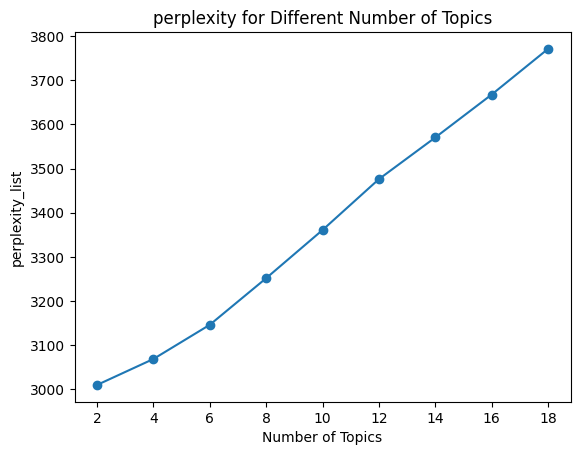

In [26]:
# perplexityのプロット
plt.figure()
plt.plot(topic_numbers, perplexity_list, marker='o')
plt.title('perplexity for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('perplexity_list')
plt.show()

In [27]:
#トピック数2で学習
Xtest_topics = models[0].transform(X_test)

#トピックごとに最も重要な5つの単語を出力
n_top_words = 10
feature_names_test = count_2.get_feature_names_out()

for topic_idx, topic in enumerate(models[0].components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names_test[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
horror series original worst minutes action tv guy script ll
Topic 2:
role family performance woman war played wife beautiful father girl


### 考察・今後の改善点
- 各トピックは10個の時より抽象的になり、上記の結果からは適切なトピック数は2個と明言することは難しいと考えた。
- トピック数を探索する別の方法を探していたところ、抽出されたトピックの品質を評価する coference と perplexity を併せて評価している事例があった。coference は scikit-learn ではサポートされていないようだったため、今回は採用しなかったが、検討の余地あり。
- 併せて単語数や出現頻度などのハイパーパラメーターを変えてもう少し探索が必要。